**Importing the required packages**



In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from pylab import rcParams

**Reading the dataset**

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/surbhi-kh/Data_Analytics/main/airline.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


**Understanding the Data** \\
1. The uploaded dataset contain a time series data, having 2 columns 'Month' and 'Passengers'.
2. Month column contain the value of month in years and for a particular month.


> 'Month' columns has datatype 'Object'. So we'll be changing the datatype to 'datetime' because panda work in that datatype.






In [3]:
df['Month'] = pd.to_datetime(df.Month) #Converting into datetime datatype
df = df.set_index(df.Month) #Set the specified column as a index
df.drop('Month', axis = 1, inplace = True) #Dropping the 'Month' Column inplace means within that dataframe
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 Passengers    int64
dtype: object


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


**Observing the data**

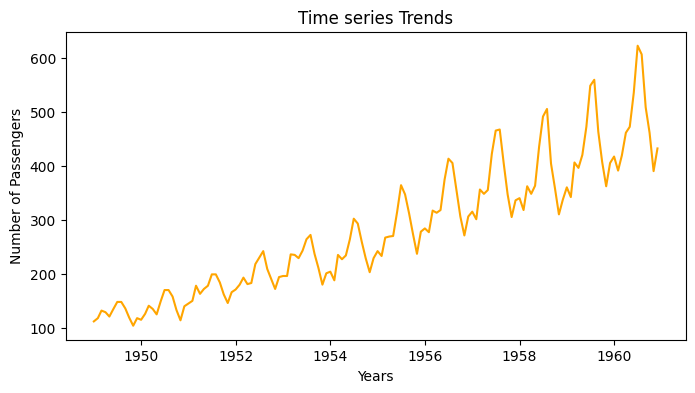

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(df, color = 'orange')
plt.xlabel("Years")
plt.ylabel("Number of Passengers")
plt.title("Time series Trends")
plt.show()

**Points for plot**
1. We can see the upward trend in the number of passenger with each passing years.
2. The variation is also increasing.
3. There is a pattern that number of passenger first increases and then decreases, which could be a sign of sesonality.



> Plotting Seasonality
1. Create a new dataframe 'df_season' and add column of Month and Year values




In [ ]:
df_season = df.copy()
df_season['Year']  = pd.DatetimeIndex(df_season.index).year
df_season['Month']  = pd.DatetimeIndex(df_season.index).month
df_season.head()

,Passengers,Year,Month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5


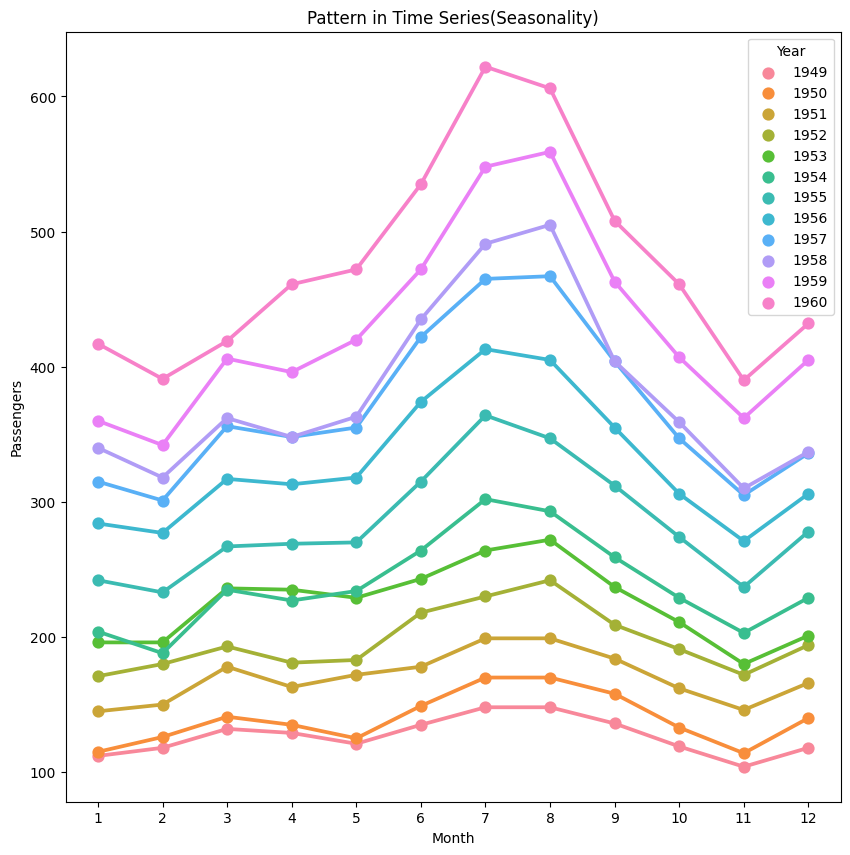

In [ ]:
#Plot
plt.figure(figsize = (10,10))
plt.title('Pattern in Time Series(Seasonality)')
sns.pointplot(x ='Month', y='Passengers', hue = 'Year', data = df_season)
plt.show()

*From the above graph we can observe that the max no. passenger are in the 7th month of the year which is JULY*

**Analysis of time series data**
1. Stationarity checking

In [ ]:
def checkStationarity(series):
  #Fetching the statictics(mean, standard deviation) for yearly data i.e usinga window = 12
  s_mean = series.rolling(window = 12).mean()
  s_std = series.rolling(window = 12).std()

  #Plot of statistics
  plt.figure(figsize = (10, 6))
  plt.grid()
  plt.xlabel('Years')
  plt.ylabel('Number of Passengers')
  plt.title('Stationarity Check of Series (Mean & Std)')
  plt.plot(series, color = 'teal', label = 'Given Series')
  plt.plot(s_mean, color = 'orange', label = 'Rolling Mean')
  plt.plot(s_std, color = 'green', label = 'Rolling Std')
  plt.legend(loc = 'upper left')
  plt.show()

  #Calculating the parameter of stationary test using Dickey-Fuller test
  print('Dickey-Fuller Test')
  df_estimate = adfuller(series)
  df_result = pd.Series(df_estimate[0:4], index = ['Test Stats', 'P-value', 'No. of Lags Used', 'Number of Observations Used'])
  for k, v in df_estimate[4].items():
    df_result['Critical Value {}'.format(k)] = v
  print(df_result)

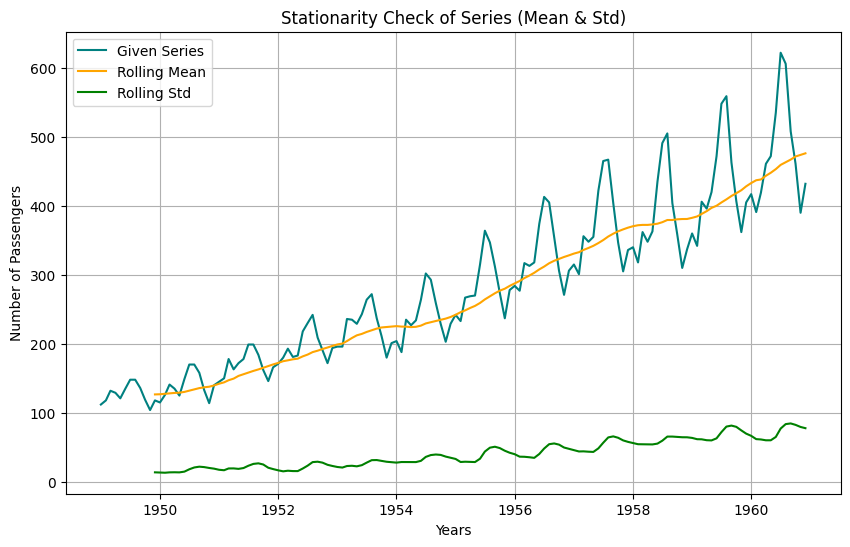

Dickey-Fuller Test
Test Stats                       0.815369
P-value                          0.991880
No. of Lags Used                13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [ ]:
checkStationarity(df['Passengers'])

*Above plot shows that the standard deviation has very little variation, however the mean is increasing so by definition of stationary data, which says mean and std has to be constant, we can say that this data is not stationary*

**Converting to Stationary Data**



---


> Log Transformation





In [ ]:
df_log = np.log(df)

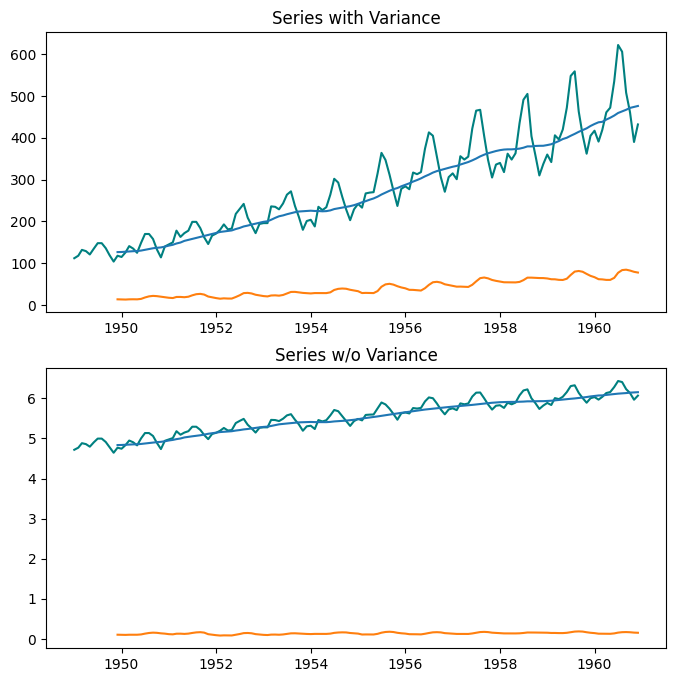

In [ ]:
#Plot of above series with and w/o variance
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.title('Series with Variance')
plt.plot(df, color = "teal") #Plot of the original data
plt.plot(df.rolling(window = 12).mean(), label = 'rolling mean') #Plot of the rolling mean of original data
plt.plot(df.rolling(window = 12).std(), label = 'rolling std') #Plot of the rolling standard deviation of original data
plt.subplot(2,1,2)
plt.title('Series w/o Variance')
plt.plot(df_log, color = 'teal') #Plot of the log transformed data
plt.plot(df_log.rolling(window = 12).mean(), label = 'rolling mean') #Plot of the rolling mean of log transformed data
plt.plot(df_log.rolling(window = 12).std(), label = 'rolling std') #Plot of the rolling standard deviation of log transformed data
plt.show()



> After the log transformation the variance is removed from the series as we can see the pattern is quite simillar



*Now, proceeding by applying the differncing method on the log transformed series*

In [ ]:
df_log_diff = df_log.diff(periods = 1) #Differencing of order 1
df_log_diff.dropna(inplace = True)

Let's check the stationarity of our transformed data

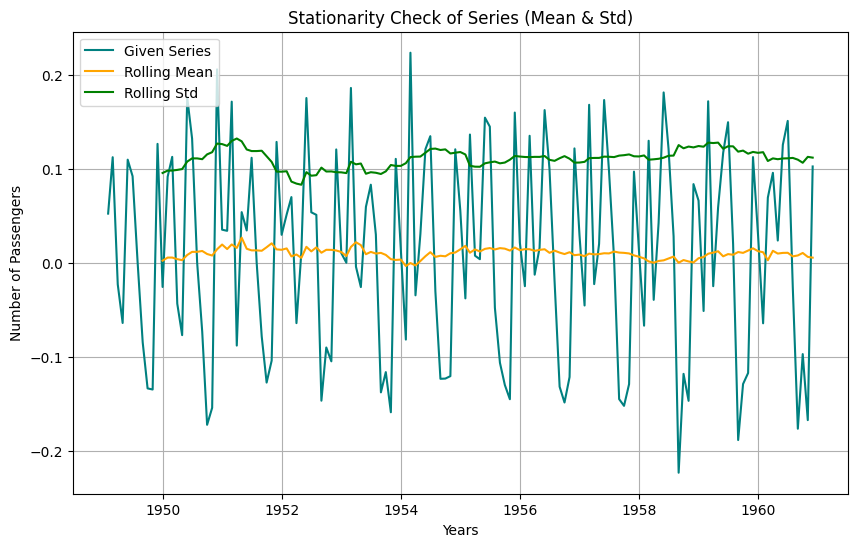

Dickey-Fuller Test
Test Stats                      -2.717131
P-value                          0.071121
No. of Lags Used                14.000000
Number of Observations Used    128.000000
Critical Value 1%               -3.482501
Critical Value 5%               -2.884398
Critical Value 10%              -2.578960
dtype: float64


In [ ]:
checkStationarity(df_log_diff)

*Since mean and standard deviation is almost constant but the p-value > 0.05 which indicate the data is still not stationary*



> Trying Moving average along with the differencing on log transformed data
1. Calculating the moving average of 'df_log' with window = 12 (yearly)
2. Taking difference of log transformed data and moving average



In [ ]:
#moving average
df_log_mvavg = df_log.rolling(window = 12).mean()
#difference 
df_log_mvavg_diff = df_log - df_log_mvavg
df_log_mvavg_diff.dropna(inplace = True)

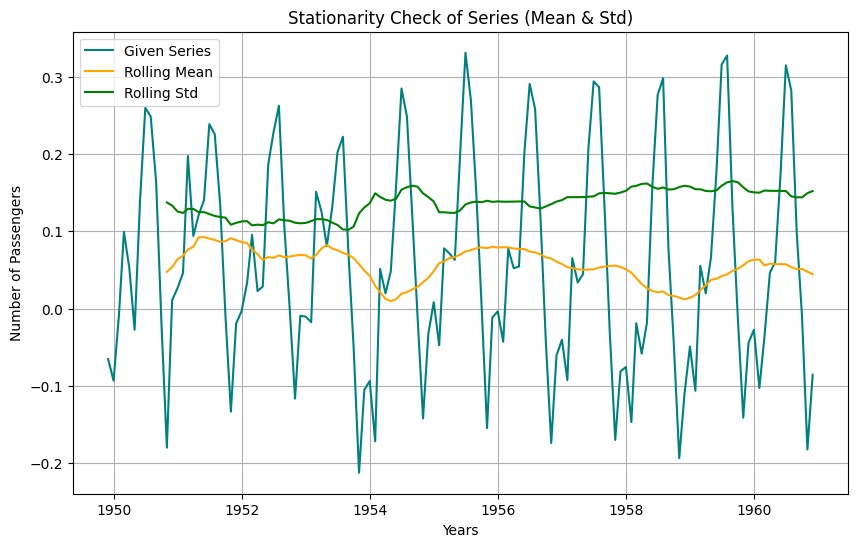

Dickey-Fuller Test
Test Stats                      -3.162908
P-value                          0.022235
No. of Lags Used                13.000000
Number of Observations Used    119.000000
Critical Value 1%               -3.486535
Critical Value 5%               -2.886151
Critical Value 10%              -2.579896
dtype: float64


In [ ]:
checkStationarity(df_log_mvavg_diff)

*Now, we can say that this is stationary data as p-value < 0.05*

**Forecasting**
1. We'll be using the 'df_log_diff' series for the forecasting. Althought this series is not completely stationary, so we'll use ARIMA (Autoregressive integrated moving average) model.
2. ARIMA has 3 parameter, 
  'p' -> Order of Autoregressive, 'q' -> Order of Moving avg, 'd' -> order of integrated part.
3. For finding out the value of p and q we'll plot ACF (Auto Correlation Function) and PACF (Partial Auto Correlation Function)
and we'll take d = 1.

**Auto Correlation Function** \\
*Order of moving average model (q) can be determined by the lag value where the ACF plot crosses the upper confidence interval for the first time*

**Partial Auto Correlation Function** \\
*Order of autoregressor model (p) can be determined by the lag value where the PACF plot crosses the upper confidence interval for the first time*


In [ ]:
q_acf = acf(df_log_mvavg_diff, nlags = 15)
p_pacf = pacf(df_log_mvavg_diff, nlags = 15, method = 'ols')

**Plotting ACF and PACF**
> 1. For finding the value of q, point at which ACF crosses the upper confidence line, we'll be using the interpolation technique to find out the intersection point.  
2. Simillary value of p is the point at which PACF crossed the upper confidence line for the first time.



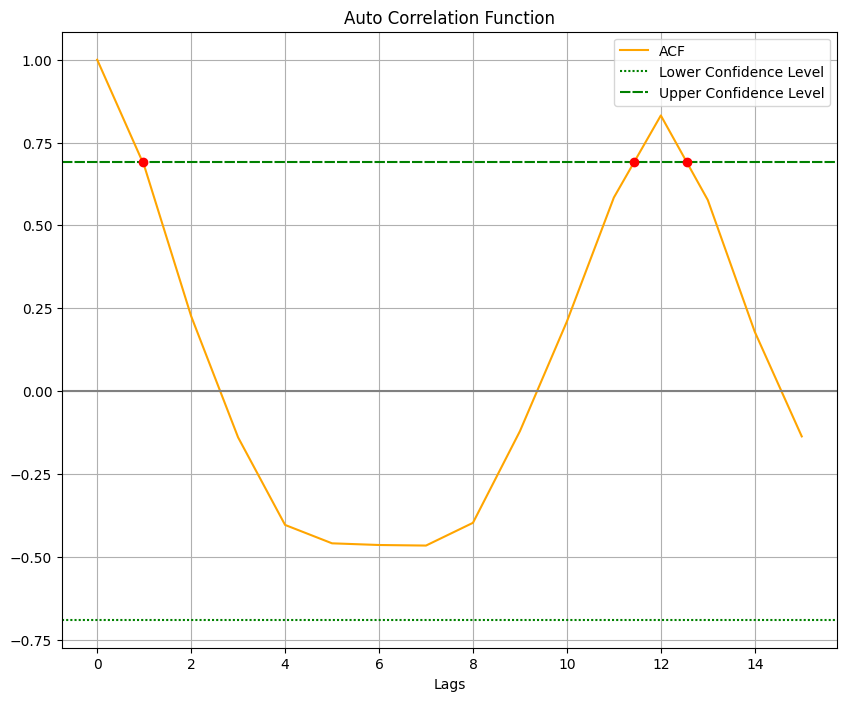

Intersection points:
Lag = 0.9700646053389623, y = 0.6902195357411994
Lag = 11.428655613456282, y = 0.6902195357411994
Lag = 12.554423186686492, y = 0.6902195357411994


In [ ]:
# Calculate the y-coordinate of the confidence lines
lower_confidence_y = -7.96 / np.sqrt(len(df_log_mvavg_diff))
upper_confidence_y = 7.96 / np.sqrt(len(df_log_mvavg_diff))

# Find the intersection points
intersection_points = []
for i in range(1, len(q_acf)):
    if (q_acf[i] > upper_confidence_y and q_acf[i-1] < upper_confidence_y) or (q_acf[i] < upper_confidence_y and q_acf[i-1] > upper_confidence_y):
        # Interpolation to find the precise intersection point
        x_inter = i - (q_acf[i] - upper_confidence_y) / (q_acf[i] - q_acf[i-1])
        y_inter = upper_confidence_y
        intersection_points.append((x_inter, y_inter))


#================================================================
# Plotting the lines and intersection points and PACF
plt.figure(figsize=(10, 8))
plt.plot(np.arange(q_acf.shape[0]), q_acf, label = "ACF", color = 'orange')
plt.grid()
plt.xlabel('Lags')
plt.title('Auto Correlation Function')
plt.axhline(y=0, linestyle='-', color='gray')
# Drawing 95% confidence interval lines
plt.axhline(y=lower_confidence_y, linestyle=(0, (1, 1)), color='green', label = 'Lower Confidence Level')
plt.axhline(y=upper_confidence_y, linestyle= (0, (5, 1)), color='green', label = 'Upper Confidence Level')
for point in intersection_points[0:3]:
    plt.plot(point[0], point[1], 'ro')  # Plotting the intersection points as red circles
plt.legend(loc = 'upper right')
plt.show()

# Print the intersection points
print("Intersection points:")
for point in intersection_points[0:3]:
    print(f"Lag = {point[0]}, y = {point[1]}")

*The above curve of ACF passes the upper confidence level at lag = 0.97 i.e 0 < lag < 1. So we can choose the optimal value of q to be 1*

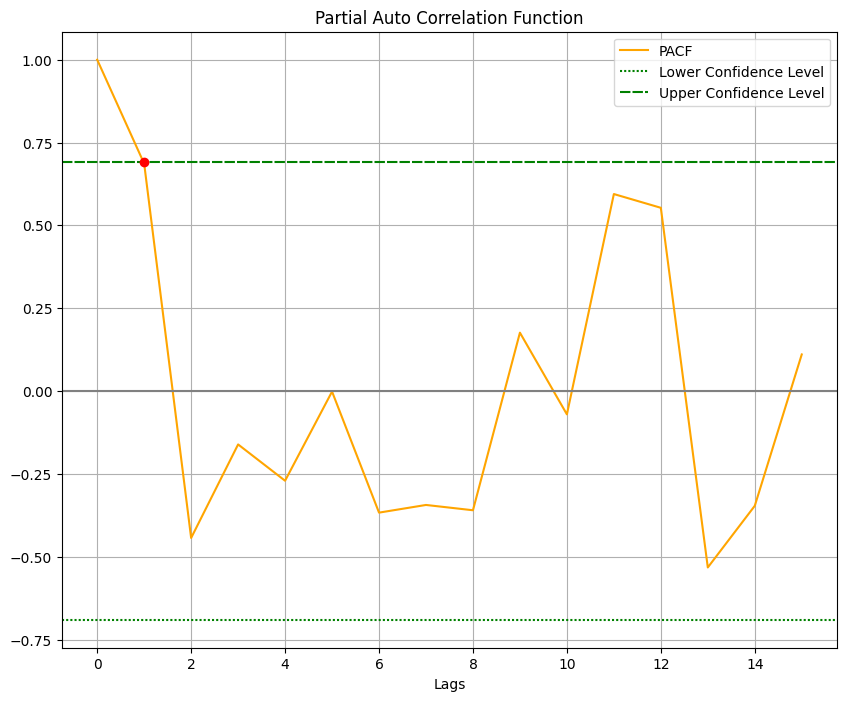

Intersection points:
Lag = 0.9874788740489082, y = 0.6902195357411994


In [ ]:
# Calculate the y-coordinate of the confidence line
confidence_y = 7.96 / np.sqrt(len(df_log_mvavg_diff))
# Find the intersection points
intersection_points = []
for i in range(1, len(p_pacf)):
    if (p_pacf[i] > confidence_y and p_pacf[i-1] < confidence_y) or (p_pacf[i] < confidence_y and p_pacf[i-1] > confidence_y):
        # Interpolation to find the precise intersection point
        x_inter = i - (p_pacf[i] - confidence_y) / (p_pacf[i] - p_pacf[i-1])
        y_inter = confidence_y
        intersection_points.append((x_inter, y_inter))
        
#============================================================
# Plotting the lines and intersection points and PACF
plt.figure(figsize = (10, 8))
plt.plot(np.arange(p_pacf.shape[0]), p_pacf, label = "PACF", color = 'orange')
plt.grid()
plt.xlabel('Lags')
plt.title('Partial Auto Correlation Function')
plt.axhline(y = 0, linestyle = '-', color = 'gray')
#Drawing 95% confidence interval line
plt.axhline(y = -7.96/np.sqrt(len(df_log_mvavg_diff)), linestyle=(0, (1, 1)), color='green', label = 'Lower Confidence Level')
plt.axhline(y = 7.96/np.sqrt(len(df_log_mvavg_diff)), linestyle= (0, (5, 1)), color='green', label = 'Upper Confidence Level')
for point in intersection_points[0:3]:
    plt.plot(point[0], point[1], 'ro')  # Plotting the intersection points as red circles
plt.legend(loc = 'upper right')
plt.show()

# Print the intersection points
print("Intersection points:")
for point in intersection_points[0:3]:
    print(f"Lag = {point[0]}, y = {point[1]}")

*The above curve of PACF passes the upper confidence level at lag = 0.987 i.e 0 < lag < 1. So we can choose the optimal value of p to be 1*



*   So the value of p  = 1 and q = 1




**Creating Models**

***Auto Regressive Integerated Moving Average Model*** \\
*In this model we'll use p, d and q as the model parameter*


In [ ]:
# freq = 'MS' > The frequency of the time-series MS = calendar month begin
# The (p,d,q) order of the model for the number of AR parameters, differences(The order of integration is the number of times the time series data is differenced), and MA parameters to use
model = sm.tsa.arima.ARIMA(df_log_mvavg_diff, order = (1, 1, 1), freq = 'MS')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
res1 = model.fit()

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  133
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 116.431
Date:                Mon, 29 May 2023   AIC                           -226.861
Time:                        19:56:38   BIC                           -218.213
Sample:                    12-01-1949   HQIC                          -223.347
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5899      0.137     -4.301      0.000      -0.859      -0.321
ma.L1          0.8980      0.074     12.210      0.000       0.754       1.042
sigma2         0.0100      0.002      5.696      0.0

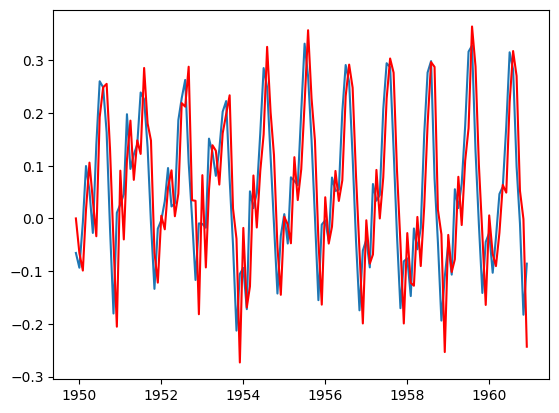

In [ ]:
plt.plot(df_log_mvavg_diff) 
plt.plot(res1.fittedvalues,color='red') #Plotting the fittedmodel
print(res1.summary())

**Prediction / Forecasting**

In [ ]:
future_dates = [df.index[-1] + DateOffset(month = x) for x in range(0,12)] #creates a list called future_dates that contains the dates of the next 12 months relative to the last date in the index of the DataFrame df
future_datest_df = pd.DataFrame(index = future_dates[1:], columns = df.columns) #=creates a new DataFrame called future_datest_df. It sets the index of the DataFrame to the dates in future_dates starting from the second element (index 1) and assigns the columns of df to future_datest_df
future_df = pd.concat([df, future_datest_df]) #Create a new datafram 'future_df' and concatenates the original DataFrame df with the future_datest_df DataFrame along the rows.
future_df['Passengers'] = res1.predict(start = 1, end = 130, dynamic = False) #It assigns the predicted values to the 'Passenger' column using the predict method from the model 'res1'. 
#Dynamic = False because we don't want our previous prediction of passenger to update recursively.
future_df.dropna(inplace = True) # Removes any rows with missing values (NaN) from the future_df DataFrame. And 'inplace = True' for making changes in original datafrae=me only 
future_df 

,Passengers
1950-01-01,-0.065494
1950-02-01,-0.098873
1950-03-01,0.016148
1950-04-01,0.105874
1950-05-01,0.034344
...,...
1960-06-01,0.048964
1960-07-01,0.220507
1960-08-01,0.317497
1960-09-01,0.270151


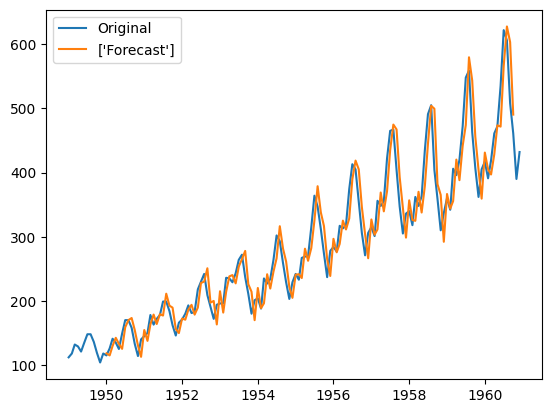

In [ ]:
plt.plot(df, label = 'Original')
# As we have used the log transformed so to get back original data we'll use exponential function
plt.plot(np.exp(future_df + df_log_mvavg), label = ['Forecast'])
plt.legend(loc = 'upper left')
plt.show()

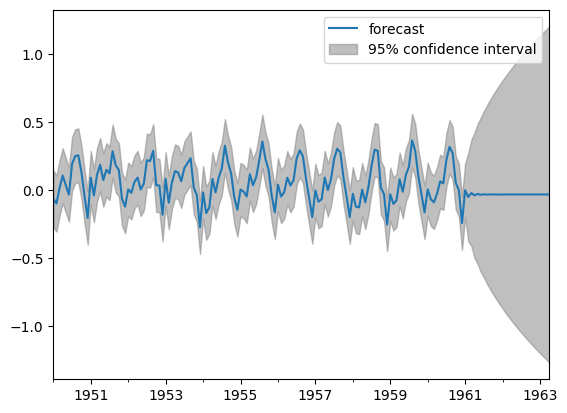

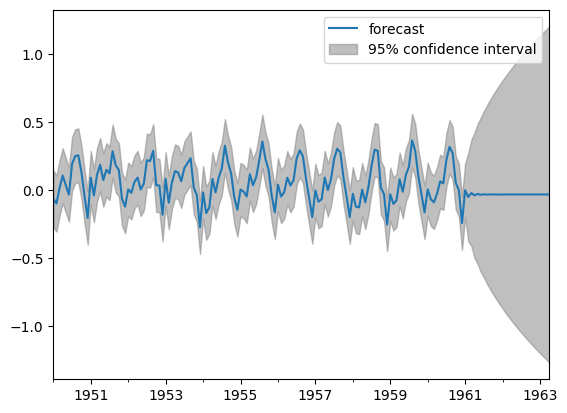

In [ ]:
plot_predict(res1, start = 1, end = 160, dynamic = False)